In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import numpy as np
from scipy import stats
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon # Positive and negative sentiment lexicon

# Hypothesis
### H0: Returns of companies with stronger net positive tone are statistically equal to the returns of companies with weaker net positive tone
### H1: Returns of companies with stronger net positive tone are statistically greater than the returns of companies with weaker net positive tone

## Data preprocessing

In [2]:
df_stocks = pd.read_csv('data/investment_analysis_nlp/stock_prices.csv')
df_stocks.shape

(320661, 3)

In [3]:
df_stocks.head()

,ticker,date,price
0,CNP,2005-01-03,8.4000
1,CNP,2005-01-04,8.3168
2,CNP,2005-01-05,8.1662
3,CNP,2005-01-06,8.1730
4,CNP,2005-01-07,8.1277


In [4]:
df_stocks.tail()

,ticker,date,price
320656,HPQ,2017-11-06,21.44
320657,HPQ,2017-11-07,21.38
320658,HPQ,2017-11-08,21.42
320659,HPQ,2017-11-09,21.34
320660,HPQ,2017-11-10,21.23


In [5]:
df_stocks['ticker'].nunique()

99

In [6]:
# Clean the date format from string to Timestamp
type(df_stocks['date'][0])
df_stocks['date'] = pd.to_datetime(df_stocks['date'], format='%Y-%m-%d')
df_stocks['date'][0]

Timestamp('2005-01-03 00:00:00')

In [7]:
df_stocks['date'].describe(datetime_is_numeric=True)

count                           320661
mean     2011-06-08 20:44:49.719048704
min                2005-01-03 00:00:00
25%                2008-03-24 00:00:00
50%                2011-06-08 00:00:00
75%                2014-08-27 00:00:00
max                2017-11-10 00:00:00
Name: date, dtype: object

In [8]:
df_stocks['returns'] = df_stocks.groupby('ticker')['price'].pct_change(1)

In [9]:
df_stocks['returns'].isna().count()

320661

In [10]:
df_stocks.dropna(subset=['returns'], inplace=True)

In [11]:
df_stocks['returns'].isna().count()

302596

In [12]:
df_stocks.head()

,ticker,date,price,returns
1,CNP,2005-01-04,8.3168,-0.009905
2,CNP,2005-01-05,8.1662,-0.018108
3,CNP,2005-01-06,8.1730,0.000833
4,CNP,2005-01-07,8.1277,-0.005543
5,CNP,2005-01-10,8.1277,0.000000


In [13]:
df_stocks.groupby('ticker')['returns'].describe()

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
A,3238.0,0.000636,0.019859,-0.110166,-0.008437,0.000763,0.010311,0.148435
ADBE,3238.0,0.000763,0.020776,-0.190346,-0.008654,0.000676,0.010372,0.143581
AES,3238.0,0.000228,0.023373,-0.157206,-0.010418,0.000477,0.010958,0.282877
AKAM,3201.0,0.000918,0.029074,-0.253120,-0.011140,0.000463,0.013407,0.240354
ALK,3201.0,0.001077,0.028163,-0.185932,-0.012498,0.000849,0.014608,0.312808
...,...,...,...,...,...,...,...,...
VIAB,1494.0,-0.000082,0.018713,-0.214829,-0.008356,0.000521,0.009426,0.138521
VZ,3238.0,0.000215,0.013150,-0.080788,-0.006447,0.000290,0.006883,0.146435
WCG,3201.0,0.001231,0.033712,-0.629504,-0.011004,0.001294,0.014254,0.240164


In [14]:
#Chech for outliers
df_stocks.groupby('ticker')['returns'].max().max()

99.3053865224251

<AxesSubplot:>

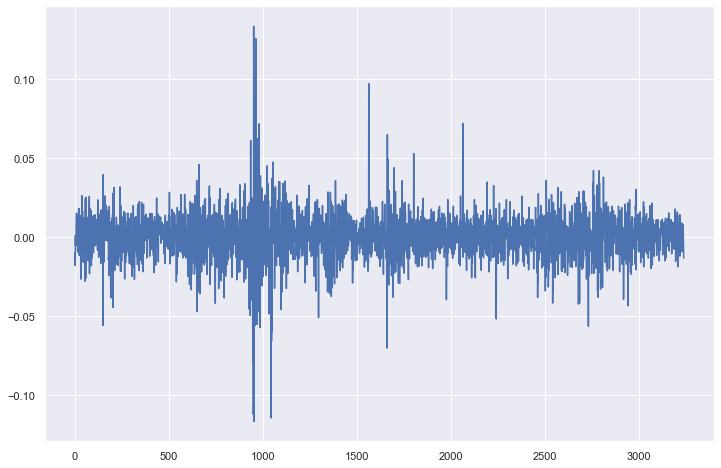

In [15]:
# Returns of induvidual stocks are random
df_stocks[df_stocks['ticker'] == 'CNP']['returns'].plot(figsize=(12,8))


<AxesSubplot:>

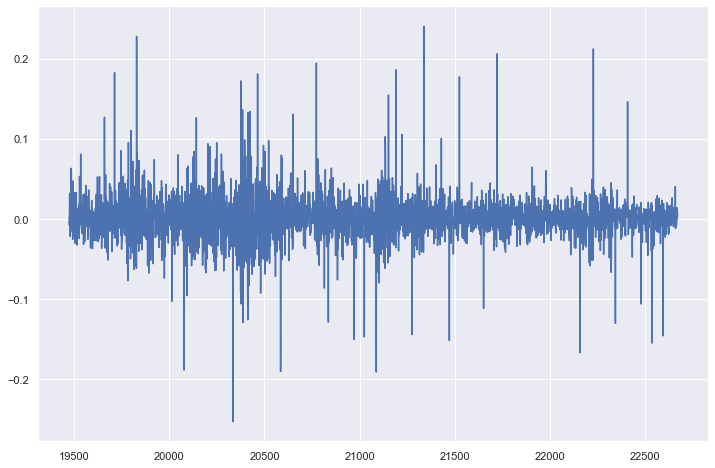

In [16]:
df_stocks[df_stocks['ticker'] == 'AKAM']['returns'].plot(figsize=(12,8))

## MDA

In [17]:
# Management and discussion and analysis
MDA_FILES = os.listdir('data/investment_analysis_nlp/mda/')
df_mda = pd.DataFrame(data=MDA_FILES)
df_mda.columns=['file_name']

In [18]:
#Extract cik, date
df_mda['cik'] = df_mda['file_name'].apply(lambda x: x.split('_')[0])
df_mda['filing_date'] = df_mda['file_name'].apply(lambda x: x.split('_')[2].split('.')[0])
df_mda['filing_date'] = pd.to_datetime(df_mda['filing_date'], format='%Y-%m-%d')
df_mda['cik'] = pd.to_numeric(df_mda['cik'])
df_mda.head()

,file_name,cik,filing_date
0,858877_MDA_2010-09-21.txt,858877,2010-09-21
1,1037540_MDA_2017-02-28.txt,1037540,2017-02-28
2,26172_MDA_2007-02-27.txt,26172,2007-02-27
3,87347_MDA_2015-01-29.txt,87347,2015-01-29
4,1087423_MDA_2009-04-29.txt,1087423,2009-04-29


In [19]:
df_mda.describe(datetime_is_numeric=True)

,cik,filing_date
count,1.364000e+03,1364
mean,6.445568e+05,2012-05-21 20:27:48.035190528
min,2.969000e+03,2005-01-14 00:00:00
25%,6.949900e+04,2008-12-18 18:00:00
50%,7.963430e+05,2012-02-29 00:00:00
75%,1.047862e+06,2016-02-18 00:00:00
max,1.681459e+06,2019-12-20 00:00:00
std,5.086819e+05,NaN


<AxesSubplot:xlabel='filing_date'>

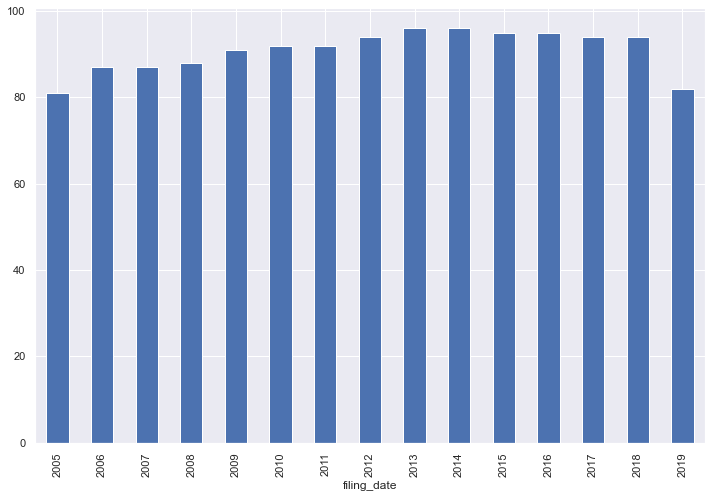

In [20]:
df_mda.groupby(df_mda['filing_date'].dt.year)['file_name'].count().plot(kind='bar', figsize=(12,8))

In [21]:
df_mda.groupby('cik')['file_name'].count().describe()

count    99.000000
mean     13.777778
std       2.659429
min       2.000000
25%      14.000000
50%      15.000000
75%      15.000000
max      16.000000
Name: file_name, dtype: float64

In [22]:
df_mda.groupby(['cik',df_mda['filing_date'].dt.year])['file_name'].count().unstack().describe()

filing_date,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
count,80.000000,84.000000,87.0,88.0,90.000000,92.0,92.0,94.0,96.0,96.0,95.0,95.0,94.0,94.0,82.0
mean,1.012500,1.035714,1.0,1.0,1.011111,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.111803,0.186691,0.0,0.0,0.105409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,2.000000,2.000000,1.0,1.0,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Cleaning the MDA text data

In [23]:
def clean_my_text(path):
    with open(path) as file:
        mda_text = file.read()
        
    words = mda_text.split()
    
    cleaned_words = [word.lower() for word in words if word.isalpha()]
    
    stopwords_nltk = set(stopwords.words("english"))
    stopwords_custom = {"management", "firm", "business", "company","property"}
    
    stopwords_combined = stopwords_nltk.union(stopwords_custom)
    
    cleaned_words = [word for word in cleaned_words if word not in stopwords_combined]
        
    return cleaned_words

# Estimating sentiment for all files that have more than 100 words


In [24]:
positive_lexicon = set(opinion_lexicon.positive())
negative_lexicon = set(opinion_lexicon.negative())

In [25]:
sentiment_scores = {}
for file in MDA_FILES:
    
    cleaned_words = clean_my_text(f'data/investment_analysis_nlp/mda/{file}')
    positive_sentiment = 0
    negative_sentiment = 0
    
    if len(cleaned_words) >= 100:
        for word in cleaned_words:
            if word in positive_lexicon:
                positive_sentiment += 1
            elif word in negative_lexicon:
                negative_sentiment += 1

        phi_pos = positive_sentiment / len(cleaned_words)
        phi_neg = negative_sentiment / len(cleaned_words)
        phi_npt = (phi_pos - phi_neg) / (phi_pos + phi_neg)


        sentiment_scores[file] = [phi_pos, phi_neg, phi_npt, len(cleaned_words)]
    else:
        pass

In [26]:
df_scores = pd.DataFrame(sentiment_scores).T
df_scores.reset_index(inplace=True)
df_scores.columns=['file_name', 'phi_pos', 'phi_neg', 'phi_npt', 'num of cleaned words']

In [27]:
df_scores.head()

,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words
0,1037540_MDA_2017-02-28.txt,0.037175,0.040892,-0.047619,269.0
1,26172_MDA_2007-02-27.txt,0.036800,0.017818,0.347548,8587.0
2,87347_MDA_2015-01-29.txt,0.045881,0.022680,0.338403,3836.0
3,1087423_MDA_2009-04-29.txt,0.035489,0.016364,0.368821,5072.0
4,72741_MDA_2009-02-27.txt,0.039797,0.016354,0.417512,19323.0


In [28]:
# Merge with df_scores with df_mda by file_name
df_scores = df_scores.merge(df_mda, on='file_name', how='inner')
df_scores.head()

,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,cik,filing_date
0,1037540_MDA_2017-02-28.txt,0.037175,0.040892,-0.047619,269.0,1037540,2017-02-28
1,26172_MDA_2007-02-27.txt,0.036800,0.017818,0.347548,8587.0,26172,2007-02-27
2,87347_MDA_2015-01-29.txt,0.045881,0.022680,0.338403,3836.0,87347,2015-01-29
3,1087423_MDA_2009-04-29.txt,0.035489,0.016364,0.368821,5072.0,1087423,2009-04-29
4,72741_MDA_2009-02-27.txt,0.039797,0.016354,0.417512,19323.0,72741,2009-02-27


<AxesSubplot:>

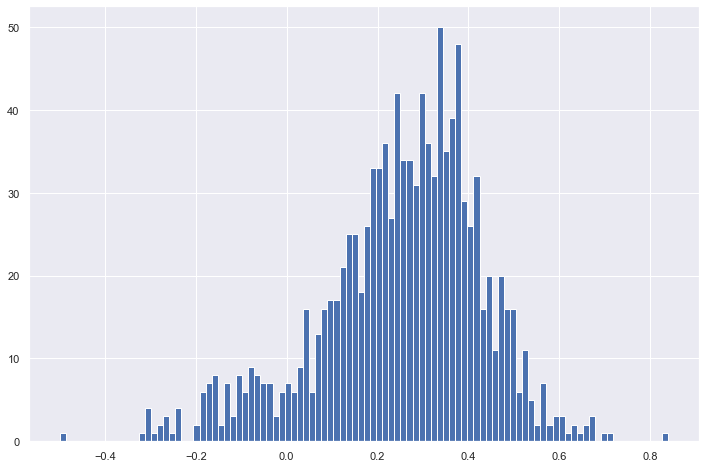

In [29]:
df_scores['phi_npt'].hist(figsize=(12,8), bins=100)

# Merging Stock and MDA data

In [30]:
# No common firm identifier
# Use crosswalk of Ticker and CIK (similar to creating a temporary table in SQL)
# Once we merge one of two datasets with the crosswalk table then we can merge Stock and MDA

In [31]:
# Load csv for SP500 companies from: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
df_crosswalk = pd.read_csv('data/investment_analysis_nlp/sp500_constituents.csv')

In [32]:
df_crosswalk.head()

,Security,Symbol,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,3M Company,MMM,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,Abbott Laboratories,ABT,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",31/03/1964,1800,1888
2,AbbVie Inc.,ABBV,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",31/12/2012,1551152,2013 (1888)
3,ABIOMED Inc,ABMD,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",31/05/2018,815094,1981
4,Accenture plc,ACN,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",06/07/2011,1467373,1989


In [33]:
df_crosswalk = df_crosswalk[['Symbol', 'CIK']]
df_crosswalk.head()

,Symbol,CIK
0,MMM,66740
1,ABT,1800
2,ABBV,1551152
3,ABMD,815094
4,ACN,1467373


In [34]:
df_stocks.head()

,ticker,date,price,returns
1,CNP,2005-01-04,8.3168,-0.009905
2,CNP,2005-01-05,8.1662,-0.018108
3,CNP,2005-01-06,8.1730,0.000833
4,CNP,2005-01-07,8.1277,-0.005543
5,CNP,2005-01-10,8.1277,0.000000


In [35]:
# Rename as in Stock and MDA dataframes
df_crosswalk.columns = ['ticker', 'cik']

In [36]:
# Merge the Stock dataset with crosswalk
df_stocks = df_stocks.merge(df_crosswalk, on='ticker', how='inner')

In [37]:
df_stocks.head()

,ticker,date,price,returns,cik
0,CNP,2005-01-04,8.3168,-0.009905,1130310
1,CNP,2005-01-05,8.1662,-0.018108,1130310
2,CNP,2005-01-06,8.1730,0.000833,1130310
3,CNP,2005-01-07,8.1277,-0.005543,1130310
4,CNP,2005-01-10,8.1277,0.000000,1130310


In [38]:
df_scores.head()

,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,cik,filing_date
0,1037540_MDA_2017-02-28.txt,0.037175,0.040892,-0.047619,269.0,1037540,2017-02-28
1,26172_MDA_2007-02-27.txt,0.036800,0.017818,0.347548,8587.0,26172,2007-02-27
2,87347_MDA_2015-01-29.txt,0.045881,0.022680,0.338403,3836.0,87347,2015-01-29
3,1087423_MDA_2009-04-29.txt,0.035489,0.016364,0.368821,5072.0,1087423,2009-04-29
4,72741_MDA_2009-02-27.txt,0.039797,0.016354,0.417512,19323.0,72741,2009-02-27


In [39]:
df_master = df_stocks.merge(df_scores, left_on=['cik', 'date'], right_on=['cik', 'filing_date'], how='left')

In [40]:
df_master[df_master['phi_npt'].notnull()]

,ticker,date,price,returns,cik,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,filing_date
49,CNP,2005-03-16,9.2306,-0.013551,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.029420,0.038549,7206.0,2005-03-16
301,CNP,2006-03-16,9.6470,-0.007714,1130310,1130310_MDA_2006-03-16.txt,0.034276,0.023056,0.195710,6506.0,2006-03-16
540,CNP,2007-02-28,13.5440,-0.001106,1130310,1130310_MDA_2007-02-28.txt,0.031512,0.022261,0.172043,6918.0,2007-02-28
792,CNP,2008-02-28,11.5980,0.001814,1130310,1130310_MDA_2008-02-28.txt,0.034323,0.022303,0.212276,6905.0,2008-02-28
1042,CNP,2009-02-25,7.9907,-0.114447,1130310,1130310_MDA_2009-02-25.txt,0.034932,0.023986,0.185792,6212.0,2009-02-25
...,...,...,...,...,...,...,...,...,...,...,...
301367,HPQ,2012-12-27,5.6096,-0.005778,47217,47217_MDA_2012-12-27.txt,0.037659,0.028565,0.137324,8577.0,2012-12-27
301620,HPQ,2013-12-30,11.4870,-0.004334,47217,47217_MDA_2013-12-30.txt,0.039578,0.036825,0.036036,8717.0,2013-12-30
301865,HPQ,2014-12-18,16.5910,0.030369,47217,47217_MDA_2014-12-18.txt,0.041076,0.033019,0.108729,8813.0,2014-12-18
302115,HPQ,2015-12-16,11.5520,0.004172,47217,47217_MDA_2015-12-16.txt,0.039996,0.032687,0.100559,9851.0,2015-12-16


In [41]:
# Convert anual tone data to daily data will produce many NaN values
# To avoid look ahead bias we won't use interpolated conversion of missing values
# Instead we will use constant conversion because tone does not change across all days in a given year

In [42]:
df_master = df_master.groupby('ticker').ffill()

In [43]:
df_master.iloc[298:305]

,date,price,returns,cik,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,filing_date
298,2006-03-13,9.6100,-0.006924,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.029420,0.038549,7206.0,2005-03-16
299,2006-03-14,9.7530,0.014880,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.029420,0.038549,7206.0,2005-03-16
300,2006-03-15,9.7220,-0.003179,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.029420,0.038549,7206.0,2005-03-16
301,2006-03-16,9.6470,-0.007714,1130310,1130310_MDA_2006-03-16.txt,0.034276,0.023056,0.195710,6506.0,2006-03-16
302,2006-03-17,9.5020,-0.015031,1130310,1130310_MDA_2006-03-16.txt,0.034276,0.023056,0.195710,6506.0,2006-03-16
303,2006-03-20,9.2656,-0.024879,1130310,1130310_MDA_2006-03-16.txt,0.034276,0.023056,0.195710,6506.0,2006-03-16
304,2006-03-21,9.2306,-0.003777,1130310,1130310_MDA_2006-03-16.txt,0.034276,0.023056,0.195710,6506.0,2006-03-16


In [44]:
# Drop the preceding rows of valid tone
df_master.dropna(inplace=True)

In [45]:
# Add the 'ticker' column
df_master = df_master.merge(df_crosswalk, on='cik', how='inner')
df_master.head()

,date,price,returns,cik,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,filing_date,ticker
0,2005-03-16,9.2306,-0.013551,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP
1,2005-03-17,9.2976,0.007258,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP
2,2005-03-18,9.3221,0.002635,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP
3,2005-03-21,9.2529,-0.007423,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP
4,2005-03-22,8.9938,-0.028002,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP


# Estimating sentiment portfolio returns

In [46]:
df_master.dtypes

date                    datetime64[ns]
price                          float64
returns                        float64
cik                              int64
file_name                       object
phi_pos                        float64
phi_neg                        float64
phi_npt                        float64
num of cleaned words           float64
filing_date             datetime64[ns]
ticker                          object
dtype: object

In [47]:
# Check for outliers
df_master['returns'].describe()

count    239519.000000
mean          0.001495
std           0.286846
min          -0.990096
25%          -0.008155
50%           0.000576
75%           0.009434
max          99.305387
Name: returns, dtype: float64

In [48]:
# Remove any return observation that is grater than (3 * std)
df_master = df_master[abs(df_master['returns']) <= (df_master['returns'].std() * 3)]
df_master['returns'].describe()

count    239512.000000
mean          0.000640
std           0.021554
min          -0.629504
25%          -0.008154
50%           0.000576
75%           0.009434
max           0.577278
Name: returns, dtype: float64

In [49]:
# Split the sample into quintiles
# 1 -> worst tone
# 5 -> best tone
df_master['quintile_tone_rank'] = df_master.groupby('date')['phi_npt'].transform(
    lambda x: pd.qcut(x=x, q=5, labels=[1,2,3,4,5] ))

# Because pd.qcut labels throw an execption with strings we manualy rename the quintiles (hacky...)
# TODO: fix
df_master.loc[df_master['quintile_tone_rank'] == 1, 'quintile_tone_rank'] = 'quintile_1'
df_master.loc[df_master['quintile_tone_rank'] == 2, 'quintile_tone_rank'] = 'quintile_2'
df_master.loc[df_master['quintile_tone_rank'] == 3, 'quintile_tone_rank'] = 'quintile_3'
df_master.loc[df_master['quintile_tone_rank'] == 4, 'quintile_tone_rank'] = 'quintile_4'
df_master.loc[df_master['quintile_tone_rank'] == 5, 'quintile_tone_rank'] = 'quintile_5'

In [50]:
df_master.head()

,date,price,returns,cik,file_name,phi_pos,phi_neg,phi_npt,num of cleaned words,filing_date,ticker,quintile_tone_rank
0,2005-03-16,9.2306,-0.013551,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP,quintile_1
1,2005-03-17,9.2976,0.007258,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP,quintile_1
2,2005-03-18,9.3221,0.002635,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP,quintile_1
3,2005-03-21,9.2529,-0.007423,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP,quintile_1
4,2005-03-22,8.9938,-0.028002,1130310,1130310_MDA_2005-03-16.txt,0.031779,0.02942,0.038549,7206.0,2005-03-16,CNP,quintile_1


In [51]:
df_master[df_master['ticker'] == 'CNP']['quintile_tone_rank'].value_counts()

quintile_2    1520
quintile_3    1274
quintile_1     395
Name: quintile_tone_rank, dtype: int64

In [52]:
df_master.groupby('quintile_tone_rank')['ticker'].value_counts().unstack()

ticker,A,ADBE,AES,AKAM,ALK,ALL,AMGN,APC,APD,ARE,...,TRIP,TROW,TSCO,ULTA,UNM,V,VAR,VIAB,WCG,ZTS
quintile_tone_rank,,,,,,,,,,,,,,,,,,,,,
quintile_1,NaN,NaN,2732.0,NaN,240.0,3203.0,254.0,224.0,250.0,497.0,...,NaN,251.0,NaN,NaN,504.0,NaN,893.0,NaN,NaN,NaN
quintile_2,746.0,NaN,445.0,252.0,209.0,NaN,1771.0,2713.0,250.0,1891.0,...,NaN,NaN,NaN,NaN,1791.0,NaN,1573.0,NaN,NaN,NaN
quintile_3,964.0,NaN,3.0,773.0,1359.0,NaN,926.0,253.0,897.0,801.0,...,NaN,NaN,137.0,NaN,896.0,1005.0,474.0,1007.0,249.0,NaN
quintile_4,764.0,938.0,NaN,978.0,1147.0,NaN,243.0,NaN,608.0,NaN,...,NaN,842.0,1310.0,343.0,NaN,251.0,60.0,250.0,1486.0,669.0
quintile_5,504.0,1776.0,NaN,1186.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1426.0,2107.0,1746.0,2070.0,NaN,NaN,NaN,NaN,1223.0,498.0


In [53]:
# Take returns of all of the firms in each quintiles and calculate the mean
# We take the mean to calculate the return on an equaly weighted portfolio
sentiment_returns = df_master.groupby(['date', 'quintile_tone_rank'])['returns'].mean().unstack()

In [54]:
sentiment_returns

quintile_tone_rank,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
date,,,,,
2005-02-24,0.020009,NaN,NaN,NaN,0.029873
2005-02-25,0.006221,NaN,NaN,NaN,0.017834
2005-02-28,-0.006721,0.002292,-0.009611,-0.006633,-0.009890
2005-03-01,0.007352,0.004593,0.024596,0.001139,0.012133
2005-03-02,-0.003139,-0.007467,0.000705,0.005407,0.001424
...,...,...,...,...,...
2017-11-06,0.002359,0.012776,0.002051,-0.003245,0.012480
2017-11-07,-0.001136,-0.001934,0.000910,0.000246,-0.013540
2017-11-08,-0.001741,0.001377,0.004139,0.004504,0.008362


In [55]:
sentiment_returns.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

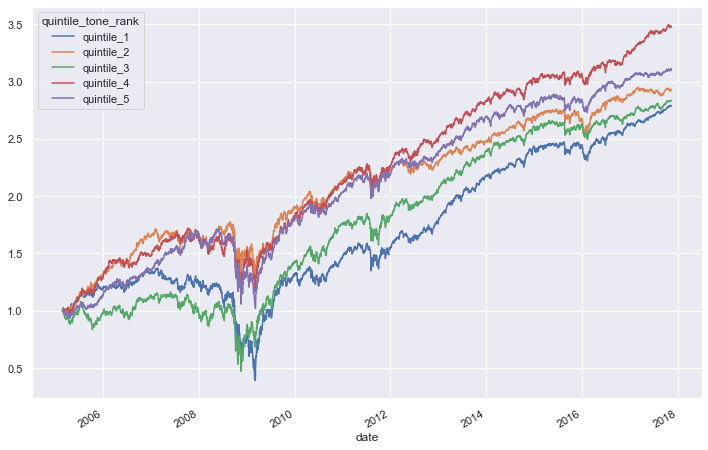

In [56]:
(1 + sentiment_returns.cumsum()).plot(figsize=(12,8))

### Out hypothesis H1 states that companies with stronger net tone have greater returns that companies with weaker net tone
### From the graph we can see that our hypothesis will not hold since Quintile_4 has the biggest returns

# Testing the Hypothesis
### We can test the null hypothesis by statistically comparing the mean return of both portfolios with the use of a t-test (Student's t-test)
### H0 of a t-test: Means of two groups are identical
### H1 of a t-test: Means of two groups are not identical
#### We will use a t-test because the t-test core hypothesis match our hypothesis

In [57]:
sentiment_returns.head()

quintile_tone_rank,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
date,,,,,
2005-02-28,-0.006721,0.002292,-0.009611,-0.006633,-0.009890
2005-03-01,0.007352,0.004593,0.024596,0.001139,0.012133
2005-03-02,-0.003139,-0.007467,0.000705,0.005407,0.001424
2005-03-03,-0.002653,0.000331,0.004094,-0.005462,-0.004653
2005-03-04,0.008558,0.020013,0.007742,0.008317,0.008014


In [58]:
# tStat
mean_diff = (sentiment_returns['quintile_5'] - sentiment_returns['quintile_1']).mean()
std_diff = (sentiment_returns['quintile_5'] - sentiment_returns['quintile_1']).std()

In [59]:
t_stat = mean_diff / (std_diff / np.sqrt(len(sentiment_returns)))
t_stat

0.7499692856260779

Let's use a scipy t-test


In [60]:
result = stats.ttest_rel(sentiment_returns['quintile_5'], sentiment_returns['quintile_1'])
result

Ttest_relResult(statistic=0.7499692856260779, pvalue=0.453328337315666)

#### As we can see 0.750 is far from ideal value of 2 and p-value is greater than 0.05 so we **cannot reject the null hypothesis**. That means that returns of companies with stronger net positive tone are statistically equal to the returns of companies with weaker net positive tone

Nevertheless let's do some Data-mining in order to find if our hypothesis holds under different conditions. 

Rather than considering all the data as a whole we will test our hypothesis in every single year.

In [61]:
sentiment_returns.head()

quintile_tone_rank,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
date,,,,,
2005-02-28,-0.006721,0.002292,-0.009611,-0.006633,-0.009890
2005-03-01,0.007352,0.004593,0.024596,0.001139,0.012133
2005-03-02,-0.003139,-0.007467,0.000705,0.005407,0.001424
2005-03-03,-0.002653,0.000331,0.004094,-0.005462,-0.004653
2005-03-04,0.008558,0.020013,0.007742,0.008317,0.008014


In [62]:
years = sentiment_returns.index.year.unique()
years = [str(year) for year in years]
years

['2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017']

In [63]:
yearly_results = {}
for year in years:
    df = sentiment_returns[year]
    result = stats.ttest_rel(df['quintile_5'], df['quintile_1'])
    yearly_results[year] = result

In [64]:
pd.DataFrame(yearly_results, index=['t_stat', 'pval'])

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
t_stat,-0.558151,0.891684,3.313743,0.680002,-0.427253,1.114934,0.594959,-0.610218,-0.99365,-1.593904,-0.00217,0.052875,-1.260401
pval,0.577327,0.373420,0.001057,0.497127,0.669561,0.265945,0.552407,0.542274,0.32135,0.112216,0.99827,0.957873,0.208878


In the year 2007 we can se that t_stat = 3.314 and p_value=0.001. That means that for the year 2007 we can reject the null in favor of the alternative with the 99%.

## Why 2007?

The year 2007 was the year of the great recession. That means that our hypothesis does not hold in general but it appears to hold in times of crisis.

In [65]:
recession_subsample = sentiment_returns['2005':'2008']
recession_subsample

quintile_tone_rank,quintile_1,quintile_2,quintile_3,quintile_4,quintile_5
date,,,,,
2005-02-28,-0.006721,0.002292,-0.009611,-0.006633,-0.009890
2005-03-01,0.007352,0.004593,0.024596,0.001139,0.012133
2005-03-02,-0.003139,-0.007467,0.000705,0.005407,0.001424
2005-03-03,-0.002653,0.000331,0.004094,-0.005462,-0.004653
2005-03-04,0.008558,0.020013,0.007742,0.008317,0.008014
...,...,...,...,...,...
2008-12-24,0.006393,-0.002409,0.006793,0.007120,0.010467
2008-12-26,0.009797,0.004723,0.010894,0.015131,0.010001
2008-12-29,-0.014796,-0.005507,-0.007463,-0.010712,-0.019247


In [66]:
stats.ttest_rel(recession_subsample['quintile_5'], recession_subsample['quintile_1'])

Ttest_relResult(statistic=1.9563443820353983, pvalue=0.05071183373592766)

<AxesSubplot:xlabel='date'>

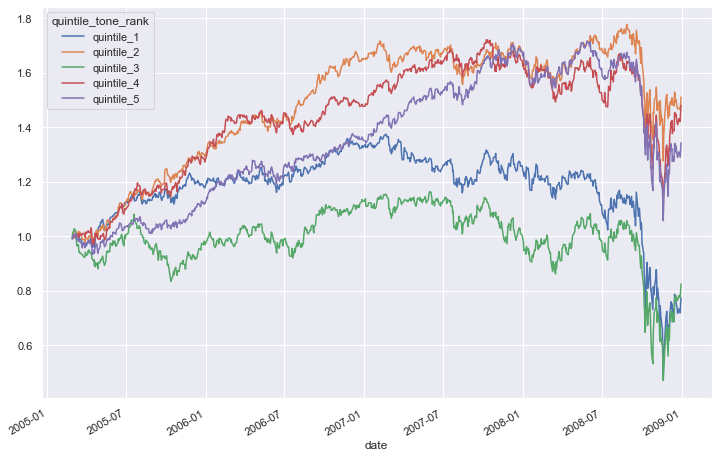

In [67]:
(1 + recession_subsample.cumsum()).plot(figsize=(12,8))

As we can see in the graph above the returns of companies in quintile_5 overtook returns of companies in quintile_1 by a great magnitude in the year 2007. Ever since gap remains as we can see in the graph below. 

<AxesSubplot:xlabel='date'>

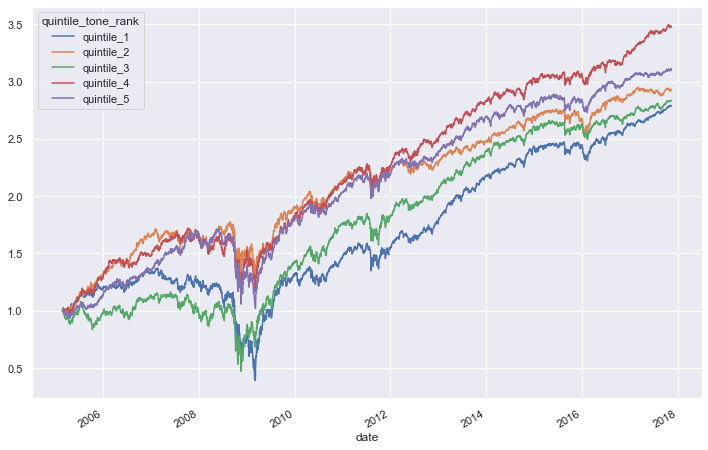

In [68]:
(1 + sentiment_returns.cumsum()).plot(figsize=(12,8))

## It appears that returns of companies with stronger net positive tone are infact statistically greater than returns of companies with weaker net postive tone durring the time of crisis.